In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

# Load datasets
train_dataset = datasets.ImageFolder(root="D:/New folder/Crack Damage Recognition.v1i.folder/train", transform=transform)
val_dataset = datasets.ImageFolder(root="D:/New folder/Crack Damage Recognition.v1i.folder/valid", transform=transform)
test_dataset = datasets.ImageFolder(root="D:/New folder/Crack Damage Recognition.v1i.folder/test", transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Print class mapping
print("Class mapping:", train_dataset.class_to_idx)  
# Expected Output: {'mild': 0, 'moderate': 1, 'no crack': 2, 'severe': 3}


Class mapping: {'mild': 0, 'moderate': 1, 'no_crack': 2, 'severe': 3}


In [3]:
# Load a pretrained model (ResNet-18) and modify the final layer
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 output classes

model = model.to(device)


C:\Users\Jibran\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Jibran\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Define loss function (CrossEntropyLoss) and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")

# Save the trained model
torch.save(model.state_dict(), "crack_severity_model.pth")
print("Model saved as crack_severity_model.pth")


  2%|█▋                                                                               | 11/525 [00:09<07:27,  1.15it/s]


KeyboardInterrupt: 

In [5]:
from PIL import Image

def predict(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")

    # Transform the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)

    return class_names[predicted_class.item()]

# Load trained model
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))
model.to(device)

# Define class labels
class_names = ["mild", "moderate", "no crack", "severe"]

# Run prediction
image_path = r"D:\New folder\Crack Damage Recognition.v1i.folder\test\severe\00083_jpg.rf.00e9dcf95f69ff32f94841f0ddb9014e.jpg"  # Change to your image path
predicted_label = predict(image_path, model, class_names)
print(f"Predicted Crack Severity: {predicted_label}")


C:\Users\Jibran\AppData\Local\Temp\ipykernel_11980\3291163353.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth

Predicted Crack Severity: severe


C:\Users\Jibran\AppData\Local\Temp\ipykernel_11980\3481867408.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth

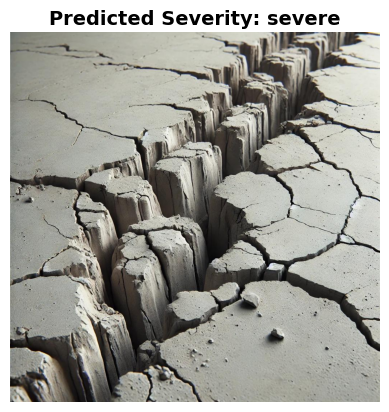

Predicted Crack Severity: severe


In [6]:
from PIL import Image
import matplotlib.pyplot as plt

def predict(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")

    # Transform the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    predicted_label = class_names[predicted_class.item()]

    # Display the image with prediction
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted Severity: {predicted_label}", fontsize=14, fontweight='bold')
    plt.show()

    return predicted_label

# Load trained model
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))
model.to(device)

# Define class labels
class_names = ["mild", "moderate", "no crack", "severe"]

# Run prediction
image_path = r"D:\OneDrive\Desktop\cracked_surface.jpg"  # Change to your image path
predicted_label = predict(image_path, model, class_names)
print(f"Predicted Crack Severity: {predicted_label}")


In [ ]:
"D:\New folder\Crack Damage Recognition.v1i.folder\test\moderate\00094_jpg.rf.3cd786675ccfce8cd5fdc34a10e375e8.jpg"

In [ ]:
"D:\New folder\Crack Damage Recognition.v1i.folder\test\mild\00026_jpg.rf.175e0f3bfffae647927e2df90d858595.jpg"

C:\Users\Jibran\AppData\Local\Temp\ipykernel_6728\3575924780.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth"

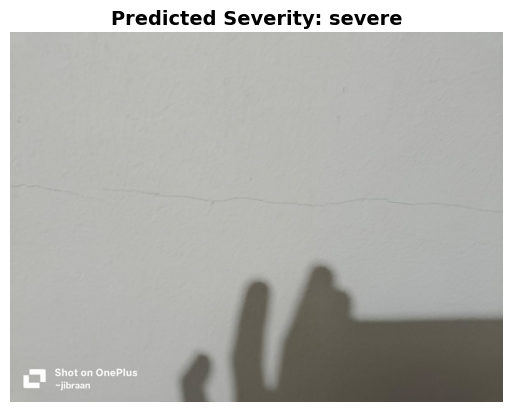

Predicted Crack Severity: severe


In [12]:
from PIL import Image
import matplotlib.pyplot as plt

def predict(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")

    # Transform the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    predicted_label = class_names[predicted_class.item()]

    # Display the image with prediction
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted Severity: {predicted_label}", fontsize=14, fontweight='bold')
    plt.show()

    return predicted_label

# Load trained model
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))
model.to(device)

# Define class labels
class_names = ["mild", "moderate", "no crack", "severe"]

# Run prediction
image_path = r"D:\OneDrive\Desktop\cs.jpg"  # Change to your image path
predicted_label = predict(image_path, model, class_names)
print(f"Predicted Crack Severity: {predicted_label}")

In [ ]:
"D:\New folder\Crack Damage Recognition.v1i.folder\test\no_crack\00107_jpg.rf.a8251e031205543e44c56b64e9b7246b.jpg"

C:\Users\Jibran\AppData\Local\Temp\ipykernel_20060\1034604556.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth

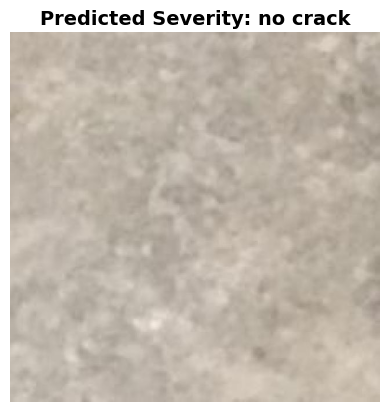

Predicted Crack Severity: no crack


In [7]:
from PIL import Image
import matplotlib.pyplot as plt

def predict(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")

    # Transform the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    predicted_label = class_names[predicted_class.item()]

    # Display the image with prediction
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted Severity: {predicted_label}", fontsize=14, fontweight='bold')
    plt.show()

    return predicted_label

# Load trained model
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))
model.to(device)

# Define class labels
class_names = ["mild", "moderate", "no crack", "severe"]

# Run prediction
image_path = r"D:\New folder\Crack Damage Recognition.v1i.folder\test\no_crack\00107_jpg.rf.a8251e031205543e44c56b64e9b7246b.jpg"  # Change to your image path
predicted_label = predict(image_path, model, class_names)
print(f"Predicted Crack Severity: {predicted_label}")

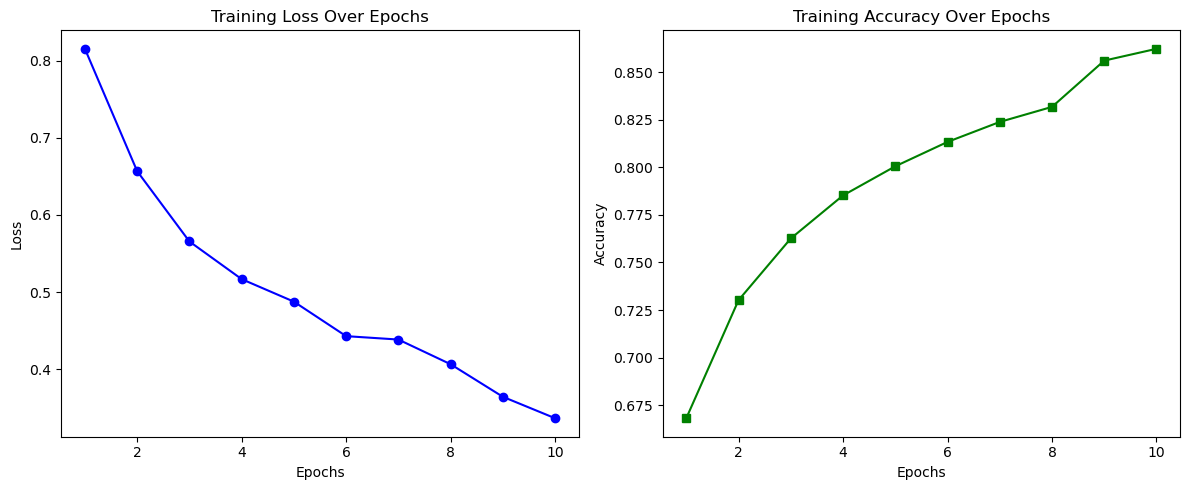

In [19]:
import matplotlib.pyplot as plt

# Manually enter the loss and accuracy values if you have them
train_losses = [0.8152, 0.6566, 0.5655, 0.5167, 0.4875, 0.4428, 0.4384, 0.4064, 0.3642, 0.3364]  # Replace with actual loss values
train_accuracies = [0.6682, 0.7302, 0.7626, 0.7852, 0.8005, 0.8133, 0.8238, 0.8317, 0.8560, 0.8622]  # Replace with actual accuracy values

num_epochs = len(train_losses)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='s', linestyle='-', color='g')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')

plt.tight_layout()
plt.show()


In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define the CrackSeverityModel
class CrackSeverityModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CrackSeverityModel, self).__init__()
        self.model = models.resnet18(pretrained=True)  
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)  # Define classifier with correct output classes

    def forward(self, x):
        return self.model(x)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CrackSeverityModel(num_classes=3).to(device)

# Load the state_dict
state_dict = torch.load("crack_severity_model.pth", map_location=device)

# Remove the last layer's parameters from the state_dict (if mismatch occurs)
filtered_state_dict = {k: v for k, v in state_dict.items() if "fc" not in k}

# Load the modified state_dict (excluding the incorrect classifier weights)
model.load_state_dict(filtered_state_dict, strict=False)

# Reinitialize the classifier layer
model.model.fc = nn.Linear(model.model.fc.in_features, 3).to(device)

# Set model to evaluation mode
model.eval()

print("Model loaded successfully with the correct number of output classes.")


Model loaded successfully with the correct number of output classes.


C:\Users\Jibran\AppData\Local\Temp\ipykernel_18764\127000919.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("crack_severity_model.pth", map_loc

In [ ]:
"D:\New folder\Crack Damage Recognition.v1i.folder\test\mild\00026_jpg.rf.175e0f3bfffae647927e2df90d858595.jpg"

C:\Users\Jibran\AppData\Local\Temp\ipykernel_20060\1939471608.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth

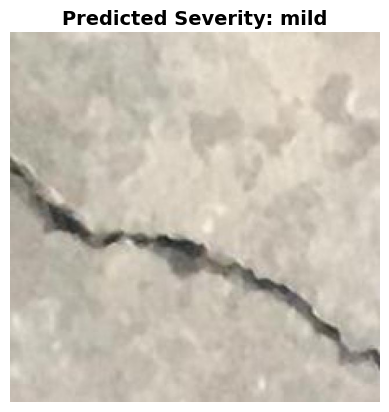

Predicted Crack Severity: mild


In [9]:
from PIL import Image
import matplotlib.pyplot as plt

def predict(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")

    # Transform the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    predicted_label = class_names[predicted_class.item()]

    # Display the image with prediction
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted Severity: {predicted_label}", fontsize=14, fontweight='bold')
    plt.show()

    return predicted_label

# Load trained model
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))
model.to(device)

# Define class labels
class_names = ["mild", "moderate", "no crack", "severe"]

# Run prediction
image_path =r"D:\New folder\Crack Damage Recognition.v1i.folder\test\mild\00026_jpg.rf.175e0f3bfffae647927e2df90d858595.jpg"# Change to your image path
predicted_label = predict(image_path, model, class_names)
print(f"Predicted Crack Severity: {predicted_label}")

In [ ]:
"D:\New folder\Crack Damage Recognition.v1i.folder\test\moderate\01904_jpg.rf.a033780f49ef7a2c85c997ba719a7448.jpg"

C:\Users\Jibran\AppData\Local\Temp\ipykernel_12228\3642113270.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth

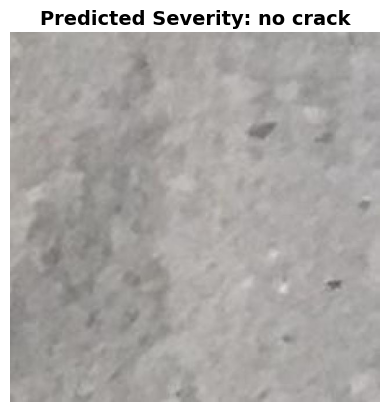

Predicted Crack Severity: no crack


In [28]:
from PIL import Image
import matplotlib.pyplot as plt

def predict(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")

    # Transform the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    predicted_label = class_names[predicted_class.item()]

    # Display the image with prediction
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted Severity: {predicted_label}", fontsize=14, fontweight='bold')
    plt.show()

    return predicted_label

# Load trained model
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))
model.to(device)

# Define class labels
class_names = ["mild", "moderate", "no crack", "severe"]

# Run prediction
image_path =r"D:\New folder\Crack Damage Recognition.v1i.folder\test\no_crack\00282_jpg.rf.e042f783a07aa07358f6241845003a66.jpg"
predicted_label = predict(image_path, model, class_names)
print(f"Predicted Crack Severity: {predicted_label}")

In [ ]:
"D:\OneDrive\Desktop\WhatsApp Image 2025-03-03 at 20.16.38_b09700e7.jpg"

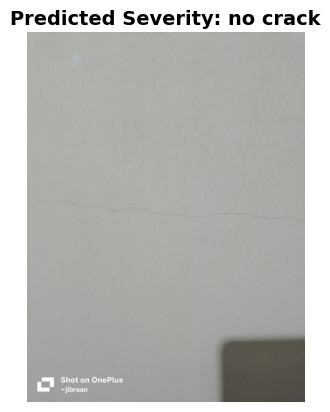

Predicted Crack Severity: no crack


In [26]:
from PIL import Image
import matplotlib.pyplot as plt

def predict(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")

    # Transform the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    predicted_label = class_names[predicted_class.item()]

    # Display the image with prediction
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted Severity: {predicted_label}", fontsize=14, fontweight='bold')
    plt.show()

    return predicted_label

# Load trained model
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))
model.to(device)

# Define class labels
class_names = ["mild", "moderate", "no crack", "severe"]

# Run prediction
image_path =r"D:\OneDrive\Desktop\WhatsApp Image 2025-03-03 at 20.16.38_b09700e7.jpg"
predicted_label = predict(image_path, model, class_names)
print(f"Predicted Crack Severity: {predicted_label}")

In [ ]:
"D:\New folder\Crack Damage Recognition.v1i.folder\test\mild\00841_jpg.rf.e26dd58a1061f8b6bf08709c0a297c5d.jpg"

C:\Users\Jibran\AppData\Local\Temp\ipykernel_12228\829808663.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth"

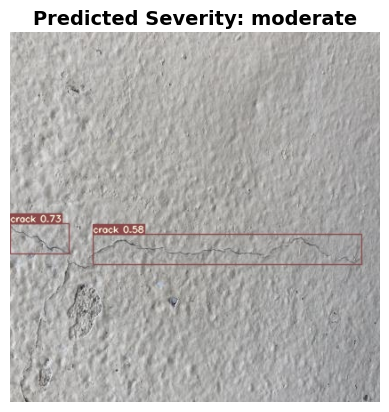

Predicted Crack Severity: moderate


In [15]:
from PIL import Image
import matplotlib.pyplot as plt

def predict(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")

    # Transform the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    predicted_label = class_names[predicted_class.item()]

    # Display the image with prediction
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted Severity: {predicted_label}", fontsize=14, fontweight='bold')
    plt.show()

    return predicted_label

# Load trained model
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))
model.to(device)

# Define class labels
class_names = ["mild", "moderate", "no crack", "severe"]

# Run prediction
image_path =r"D:\OneDrive\Desktop\1616.rf.c868709931a671796794fdbb95352c5a.jpg"
predicted_label = predict(image_path, model, class_names)
print(f"Predicted Crack Severity: {predicted_label}")

In [3]:
pip list | grep yolov7


Note: you may need to restart the kernel to use updated packages.


'grep' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
"D:\OneDrive\Desktop\test2.jpg"

In [21]:
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 3-channel normalization
])

def predict_frame(frame, model, class_names, device):
    model.eval()
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    return class_names[predicted_class.item()]

# Load the correct model architecture (ResNet18 as an example)
model = models.resnet18(pretrained=False)  # Use resnet50 or another variant if required
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)  # Adjust for 4 output classes
model.to(device)

# Load trained model weights
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))

# Define class labels
class_names = ["mild", "moderate", "no crack", "severe"]

# Open video file or camera
video_path = r"D:\OneDrive\Desktop\test video.mp4"  # Change to 0 for webcam
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    predicted_label = predict_frame(frame, model, class_names, device)

    # Display prediction on frame
    cv2.putText(frame, f"Severity: {predicted_label}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow("Crack Severity Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


C:\Users\Jibran\AppData\Local\Temp\ipykernel_20060\2402644931.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth

In [15]:
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 3-channel normalization
])

# Repair suggestions based on severity level
repair_suggestions = {
    "no crack": "No repair needed.",
    "mild": "Apply sealant or crack filler.",
    "moderate": "Use epoxy injection or patching compound.",
    "severe": "Structural repair required. Consult an engineer."
}

def predict_frame(frame, model, class_names, device):
    model.eval()
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    return class_names[predicted_class.item()]

# Load the correct model architecture (ResNet18 as an example)
model = models.resnet18(pretrained=False)  # Use resnet50 or another variant if required
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)  # Adjust for 4 output classes
model.to(device)

# Load trained model weights
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))

# Define class labels
class_names = ["mild", "moderate", "no crack", "severe"]

# Open video file or camera
video_path = r"D:\OneDrive\Desktop\test video.mp4"  # Change to 0 for webcam
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    predicted_label = predict_frame(frame, model, class_names, device)
    suggestion = repair_suggestions[predicted_label]

    # Display prediction and suggestion on frame
    cv2.putText(frame, f"Severity: {predicted_label}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0, 255, 0), 2, cv2.LINE_AA)
    
    cv2.putText(frame, f"Repair: {suggestion}", (30, 90), cv2.FONT_HERSHEY_SIMPLEX, 
                0.8, (255, 0, 0), 2, cv2.LINE_AA)

    cv2.imshow("Crack Severity Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


C:\Users\Jibran\AppData\Local\Temp\ipykernel_11980\2253027981.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth

In [9]:
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 3-channel normalization
])

# Repair suggestions based on severity level
repair_suggestions = {
    "no crack": "No repair needed.",
    "mild": "Apply sealant or crack filler.",
    "moderate": "Use epoxy injection or patching compound.",
    "severe": "Structural repair required. Consult an engineer."
}

def predict_frame(frame, model, class_names, device):
    model.eval()
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    return class_names[predicted_class.item()]

# Load the correct model architecture (ResNet18 as an example)
model = models.resnet18(pretrained=False)  # Use resnet50 or another variant if required
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)  # Adjust for 4 output classes
model.to(device)

# Load trained model weights
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))

# Define class labels
class_names = ["mild", "moderate", "no crack", "severe"]

# Open video file or camera
video_path = r"D:\OneDrive\Desktop\test video.mp4"  # Change to 0 for webcam
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    predicted_label = predict_frame(frame, model, class_names, device)
    suggestion = repair_suggestions[predicted_label]

    # Display prediction and suggestion on frame
    cv2.putText(frame, f"Severity: {predicted_label}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0, 255, 0), 2, cv2.LINE_AA)
    
    cv2.putText(frame, f"Repair: {suggestion}", (30, 90), cv2.FONT_HERSHEY_SIMPLEX, 
                0.8, (255, 0, 0), 2, cv2.LINE_AA)

    # Convert frame to grayscale for edge detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)  # Detect edges

    # Convert edges to 3-channel image (black background, white cracks)
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    # Show both windows
    cv2.imshow("Crack Severity Detection", frame)
    cv2.imshow("Detected Cracks", edges_colored)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


C:\Users\Jibran\AppData\Local\Temp\ipykernel_11980\2419625984.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth

In [14]:
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 3-channel normalization
])

# Repair suggestions based on severity level
repair_suggestions = {
    "no crack": "No repair needed.",
    "mild": "Apply sealant or crack filler.",
    "moderate": "Use epoxy injection or patching compound.",
    "severe": "Structural repair required. Consult an engineer."
}

def predict_frame(frame, model, class_names, device):
    model.eval()
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    return class_names[predicted_class.item()]

# Load the correct model architecture (ResNet18 as an example)
model = models.resnet18(pretrained=False)  # Use resnet50 or another variant if required
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)  # Adjust for 4 output classes
model.to(device)

# Load trained model weights
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))

# Define class labels
class_names = ["mild", "moderate", "no crack", "severe"]

# Open video file or camera
video_path = r"D:\OneDrive\Desktop\WhatsApp Video 2025-03-12 at 13.16.00_69d8b651.mp4"  # Change to 0 for webcam
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    predicted_label = predict_frame(frame, model, class_names, device)
    suggestion = repair_suggestions[predicted_label]

    # Display prediction and suggestion on frame
    cv2.putText(frame, f"Severity: {predicted_label}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0, 255, 0), 2, cv2.LINE_AA)
    
    cv2.putText(frame, f"Repair: {suggestion}", (30, 90), cv2.FONT_HERSHEY_SIMPLEX, 
                0.8, (255, 0, 0), 2, cv2.LINE_AA)

    # Convert frame to grayscale for edge detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Canny edge detection to detect cracks
    edges = cv2.Canny(blurred, 50, 150)

    # Convert edges to a binary black & white image (ensuring cracks are white)
    _, binary_edges = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)

    # Increase visibility of cracks (dilate white lines)
    kernel = np.ones((3, 3), np.uint8)
    enhanced_edges = cv2.dilate(binary_edges, kernel, iterations=1)

    # Convert to 3-channel image for proper display
    edges_colored = cv2.cvtColor(enhanced_edges, cv2.COLOR_GRAY2BGR)

    # Show both windows
    cv2.imshow("Crack Severity Detection", frame)
    cv2.imshow("Detected Cracks", edges_colored)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


C:\Users\Jibran\AppData\Local\Temp\ipykernel_11980\1572021990.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth

In [13]:
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformation for model input
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for 3 channels
])

# Crack severity labels and repair suggestions
class_names = ["mild", "moderate", "no crack", "severe"]
repair_suggestions = {
    "no crack": "No repair needed.",
    "mild": "Apply sealant or crack filler.",
    "moderate": "Use epoxy injection or patching compound.",
    "severe": "Structural repair required. Consult an engineer."
}

def predict_frame(frame, model, device):
    """Predicts crack severity from the frame using the trained model."""
    model.eval()
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert OpenCV frame to PIL image
    img_tensor = transform(img).unsqueeze(0).to(device)  # Transform & add batch dimension

    with torch.no_grad():
        output = model(img_tensor)
        _, predicted_class = torch.max(output, 1)

    return class_names[predicted_class.item()]

def detect_cracks(frame):
    """Applies edge detection and enhancement to visualize cracks."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Reduce noise

    # Canny edge detection for cracks
    edges = cv2.Canny(blurred, 50, 150)

    # Convert to binary black & white image
    _, binary_edges = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)

    # Increase visibility of cracks using dilation
    kernel = np.ones((3, 3), np.uint8)
    enhanced_edges = cv2.dilate(binary_edges, kernel, iterations=1)

    # Convert to 3-channel image for display
    return cv2.cvtColor(enhanced_edges, cv2.COLOR_GRAY2BGR)

# Load trained model (ResNet18 as example)
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)  # 4 classes: mild, moderate, no crack, severe
model.to(device)

# Load model weights
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))

# Open video file or webcam
video_path = r"D:\OneDrive\Desktop\WhatsApp Video 2025-03-12 at 13.16.00_69d8b651.mp4"  # Change to 0 for webcam
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Predict severity
    predicted_label = predict_frame(frame, model, device)
    suggestion = repair_suggestions[predicted_label]

    # Detect cracks
    crack_visualization = detect_cracks(frame)

    # Overlay severity and repair suggestion
    cv2.putText(frame, f"Severity: {predicted_label}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(frame, f"Repair: {suggestion}", (30, 90), cv2.FONT_HERSHEY_SIMPLEX, 
                0.8, (255, 0, 0), 2, cv2.LINE_AA)

    # Display both windows
    cv2.imshow("Crack Severity Detection", frame)
    cv2.imshow("Detected Cracks", crack_visualization)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


C:\Users\Jibran\AppData\Local\Temp\ipykernel_11980\2456598258.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth

In [24]:
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 3-channel normalization
])

# Repair suggestions based on severity level
repair_suggestions = {
    "no crack": "No repair needed.",
    "mild": "Apply sealant or crack filler.",
    "moderate": "Use epoxy injection or patching compound.",
    "severe": "Structural repair required. Consult an engineer."
}

def predict_frame(frame, model, class_names, device):
    model.eval()
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    return class_names[predicted_class.item()]

# Load the correct model architecture (ResNet18 as an example)
model = models.resnet18(pretrained=False)  # Use resnet50 or another variant if required
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)  # Adjust for 4 output classes
model.to(device)

# Load trained model weights
state_dict = torch.load("crack_severity_model.pth", map_location=device)
if any(k.startswith("module.") for k in state_dict.keys()):
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
model.load_state_dict(state_dict, strict=False)
model.to(device)
model.eval()

# Define class labels
class_names = ["mild", "moderate", "no crack", "severe"]

# Load and process the image
image_path = r"D:\OneDrive\Desktop\image1.jpeg"  # Change this to your image file path
image = cv2.imread(image_path)
predicted_label = predict_frame(image, model, class_names, device)
suggestion = repair_suggestions[predicted_label]

# Display prediction and suggestion on image
cv2.putText(image, f"Severity: {predicted_label}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 
            1, (0, 255, 0), 2, cv2.LINE_AA)
cv2.putText(image, f"Repair: {suggestion}", (30, 90), cv2.FONT_HERSHEY_SIMPLEX, 
            0.8, (255, 0, 0), 2, cv2.LINE_AA)

# Convert image to grayscale for edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Canny edge detection to detect cracks
edges = cv2.Canny(blurred, 50, 150)

# Convert edges to a binary black & white image (ensuring cracks are white)
_, binary_edges = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)

# Increase visibility of cracks (dilate white lines)
kernel = np.ones((3, 3), np.uint8)
enhanced_edges = cv2.dilate(binary_edges, kernel, iterations=1)

# Convert to 3-channel image for proper display
edges_colored = cv2.cvtColor(enhanced_edges, cv2.COLOR_GRAY2BGR)

# Show both images
cv2.imshow("Crack Severity Detection", image)
cv2.imshow("Detected Cracks", edges_colored)
cv2.waitKey(0)
cv2.destroyAllWindows()

C:\Users\Jibran\AppData\Local\Temp\ipykernel_12228\2246566672.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("crack_severity_model.pth", map_lo

In [29]:
## for folder

In [31]:
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import os

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Repair suggestions
repair_suggestions = {
    "no crack": "No repair needed.",
    "mild": "Apply sealant or crack filler.",
    "moderate": "Use epoxy injection or patching compound.",
    "severe": "Structural repair required. Consult an engineer."
}

# Load model
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))
model.to(device)
model.eval()

# Class labels
class_names = ["mild", "moderate", "no crack", "severe"]

def predict_severity(image, model, class_names, device):
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)
    return class_names[predicted_class.item()]

def detect_cracks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    _, binary_edges = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)
    kernel = np.ones((3, 3), np.uint8)
    enhanced_edges = cv2.dilate(binary_edges, kernel, iterations=1)
    return cv2.cvtColor(enhanced_edges, cv2.COLOR_GRAY2BGR)

def process_folder(folder_path, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('png', 'jpg', 'jpeg')):
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path)
            pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            
            severity = predict_severity(pil_image, model, class_names, device)
            suggestion = repair_suggestions[severity]
            
            # Draw severity text on image
            cv2.putText(image, f"Severity: {severity}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # Perform crack detection
            crack_edges = detect_cracks(image)
            
            # Save results
            cv2.imwrite(os.path.join(output_folder, f"severity_{filename}"), image)
            cv2.imwrite(os.path.join(output_folder, f"cracks_{filename}"), crack_edges)
            
            print(f"Processed: {filename} - Severity: {severity}")

# Define input and output folder paths
input_folder = r"D:\OneDrive\Desktop\test"  # Change to your folder path
output_folder = "output_results"

process_folder(input_folder, output_folder)

C:\Users\Jibran\AppData\Local\Temp\ipykernel_12228\184158902.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth"

Processed: WhatsApp Image 2025-03-15 at 16.58.50_05c1c735.jpg - Severity: moderate
Processed: WhatsApp Image 2025-03-15 at 16.58.50_f7297b6f.jpg - Severity: mild


In [16]:
pip install opencv-python torch torchvision numpy pillow


Note: you may need to restart the kernel to use updated packages.


In [18]:
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 3-channel normalization
])

# Repair suggestions based on severity level
repair_suggestions = {
    "no crack": "No repair needed.",
    "mild": "Apply sealant or crack filler.",
    "moderate": "Use epoxy injection or patching compound.",
    "severe": "Structural repair required. Consult an engineer."
}

def predict_frame(frame, model, class_names, device):
    model.eval()
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    return class_names[predicted_class.item()]

# Load the correct model architecture (ResNet18 as an example)
model = models.resnet18(pretrained=False)  # Use resnet50 or another variant if required
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)  # Adjust for 4 output classes
model.to(device)

# Load trained model weights
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))

# Define class labels
class_names = ["mild", "moderate", "no crack", "severe"]

# Open the external webcam (use index 1 if needed)
cap = cv2.VideoCapture(0)  # Change to 1 if the external webcam is not detected

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    predicted_label = predict_frame(frame, model, class_names, device)
    suggestion = repair_suggestions[predicted_label]

    # Display prediction and suggestion on frame
    cv2.putText(frame, f"Severity: {predicted_label}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0, 255, 0), 2, cv2.LINE_AA)
    
    cv2.putText(frame, f"Repair: {suggestion}", (30, 90), cv2.FONT_HERSHEY_SIMPLEX, 
                0.8, (255, 0, 0), 2, cv2.LINE_AA)

    cv2.imshow("Crack Severity Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


C:\Users\Jibran\AppData\Local\Temp\ipykernel_11980\3685452284.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth

In [19]:
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformation to match training preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Ensure this matches training conditions
])

# Repair suggestions based on severity level
repair_suggestions = {
    "no crack": "No repair needed.",
    "mild": "Apply sealant or crack filler.",
    "moderate": "Use epoxy injection or patching compound.",
    "severe": "Structural repair required. Consult an engineer."
}

def predict_frame(frame, model, class_names, device, confidence_threshold=0.6):
    model.eval()
    
    # Convert frame from BGR (OpenCV) to RGB
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)

    # Apply confidence threshold
    if confidence.item() < confidence_threshold:
        return "No crack detected", "No repair needed."

    predicted_label = class_names[predicted_class.item()]
    suggestion = repair_suggestions[predicted_label]

    return predicted_label, suggestion

# Load the model (ResNet18 as an example)
model = models.resnet18(pretrained=False)  # Use resnet50 or another variant if required
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)  # Adjust for 4 output classes
model.to(device)

# Load trained model weights
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))

# Define class labels
class_names = ["mild", "moderate", "no crack", "severe"]

# Open external camera (adjust index if needed)
cap = cv2.VideoCapture(0)  # Change index if the external camera is not at index 0

if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture image")
        break

    # Debug: Show input frame before processing
    cv2.imshow("Debug Frame", frame)
    
    predicted_label, suggestion = predict_frame(frame, model, class_names, device)

    # Display prediction and suggestion on frame
    cv2.putText(frame, f"Severity: {predicted_label}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0, 255, 0), 2, cv2.LINE_AA)
    
    cv2.putText(frame, f"Repair: {suggestion}", (30, 90), cv2.FONT_HERSHEY_SIMPLEX, 
                0.8, (255, 0, 0), 2, cv2.LINE_AA)

    cv2.imshow("Crack Severity Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to quit
        break

cap.release()
cv2.destroyAllWindows()


C:\Users\Jibran\AppData\Local\Temp\ipykernel_11980\1076345567.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth

In [21]:
!pip install torch torchvision opencv-python numpy matplotlib
!git clone https://github.com/ultralytics/yolov5.git  # Clone YOLOv5 repo
!cd yolov5 && pip install -r requirements.txt


'git' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.


In [25]:
import sys
sys.path.append('./yolov5')  # Add YOLOv5 to system path


In [24]:
import os
print(os.getcwd())  # Prints the current working directory


C:\Users\Jibran


In [27]:
import sys
sys.path.append(os.getcwd() + "/yolov5")


In [28]:
import sys
sys.path.append("C:/Users/Jibran/Documents/yolov5")


C:\Users\Jibran\AppData\Local\Temp\ipykernel_2156\4274167619.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth"

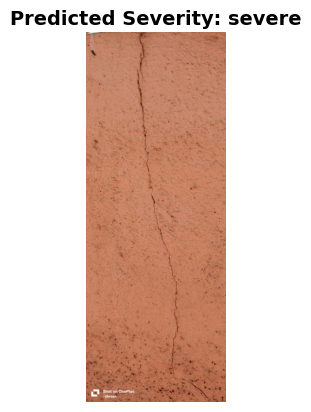

Predicted Crack Severity: severe


In [7]:
from PIL import Image
import matplotlib.pyplot as plt

def predict(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")

    # Transform the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    predicted_label = class_names[predicted_class.item()]

    # Display the image with prediction
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted Severity: {predicted_label}", fontsize=14, fontweight='bold')
    plt.show()

    return predicted_label

# Load trained model
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))
model.to(device)

# Define class labels
class_names = ["mild", "moderate", "no crack", "severe"]

# Run prediction
image_path =r"D:\OneDrive\Desktop\ti1.jpg"
predicted_label = predict(image_path, model, class_names)
print(f"Predicted Crack Severity: {predicted_label}")

In [6]:
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformation for model input
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for 3 channels
])

# Crack severity labels and repair suggestions
class_names = ["mild", "moderate", "no crack", "severe"]
repair_suggestions = {
    "no crack": "No repair needed.",
    "mild": "Apply sealant or crack filler.",
    "moderate": "Use epoxy injection or patching compound.",
    "severe": "Structural repair required. Consult an engineer."
}

def predict_frame(frame, model, device):
    """Predicts crack severity from the frame using the trained model."""
    model.eval()
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert OpenCV frame to PIL image
    img_tensor = transform(img).unsqueeze(0).to(device)  # Transform & add batch dimension

    with torch.no_grad():
        output = model(img_tensor)
        _, predicted_class = torch.max(output, 1)

    return class_names[predicted_class.item()]

def detect_cracks(frame):
    """Applies edge detection and enhancement to visualize cracks."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Reduce noise

    # Canny edge detection for cracks
    edges = cv2.Canny(blurred, 50, 150)

    # Convert to binary black & white image
    _, binary_edges = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)

    # Increase visibility of cracks using dilation
    kernel = np.ones((3, 3), np.uint8)
    enhanced_edges = cv2.dilate(binary_edges, kernel, iterations=1)

    # Convert to 3-channel image for display
    return cv2.cvtColor(enhanced_edges, cv2.COLOR_GRAY2BGR)

# Load trained model (ResNet18 as example)
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)  # 4 classes: mild, moderate, no crack, severe
model.to(device)

# Load model weights
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))

# Open video file or webcam
video_path = r"D:\OneDrive\Desktop\tv6.mp4" # Change to 0 for webcam
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Predict severity
    predicted_label = predict_frame(frame, model, device)
    suggestion = repair_suggestions[predicted_label]

    # Detect cracks
    crack_visualization = detect_cracks(frame)

    # Overlay severity and repair suggestion
    cv2.putText(frame, f"Severity: {predicted_label}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(frame, f"Repair: {suggestion}", (30, 90), cv2.FONT_HERSHEY_SIMPLEX, 
                0.8, (255, 0, 0), 2, cv2.LINE_AA)

    # Display both windows
    cv2.imshow("Crack Severity Detection", frame)
    cv2.imshow("Detected Cracks", crack_visualization)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


C:\Users\Jibran\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Jibran\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Jibran\AppData\Local\Temp\ipykernel_2156\3139889347.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be fli

In [ ]:
"D:\New folder\Crack Damage Recognition.v1i.folder\test\severe\01343_jpg.rf.39ef1af751c9d4ac0859290237f503da.jpg"

C:\Users\Jibran\AppData\Local\Temp\ipykernel_2156\3159447808.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth"

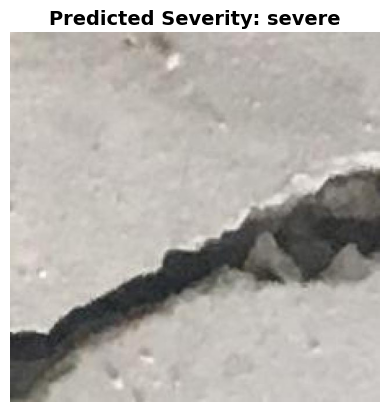

Predicted Crack Severity: severe


In [8]:
from PIL import Image
import matplotlib.pyplot as plt

def predict(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")

    # Transform the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    predicted_label = class_names[predicted_class.item()]

    # Display the image with prediction
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted Severity: {predicted_label}", fontsize=14, fontweight='bold')
    plt.show()

    return predicted_label

# Load trained model
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))
model.to(device)

# Define class labels
class_names = ["mild", "moderate", "no crack", "severe"]

# Run prediction
image_path =r"D:\New folder\Crack Damage Recognition.v1i.folder\test\severe\01343_jpg.rf.39ef1af751c9d4ac0859290237f503da.jpg"
predicted_label = predict(image_path, model, class_names)
print(f"Predicted Crack Severity: {predicted_label}")

In [10]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 output classes
model.load_state_dict(torch.load("crack_severity_model.pth", map_location=device))
model.to(device)
model.eval()

# Define image transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_crack_severity(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)  # Get probabilities
        predicted_class = torch.argmax(probabilities, dim=1).item()
    
    severity_classes = ["Mild", "Moderate", "Severe", "No_crack"]
    
    print(f"Predicted Crack Severity: {severity_classes[predicted_class]}")
    print(f"Confidence Scores: {probabilities.cpu().numpy()}")

    return severity_classes[predicted_class], probabilities.cpu().numpy()

# Example usage
image_path = r"D:\OneDrive\Desktop\ti1.jpg"
severity, confidence = predict_crack_severity(image_path)


C:\Users\Jibran\AppData\Local\Temp\ipykernel_2156\2751079592.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_severity_model.pth"

Predicted Crack Severity: No_crack
Confidence Scores: [[9.9585644e-12 2.5132271e-08 4.1967348e-40 1.0000000e+00]]
